### MULTIPLE LINEAR REGRESSION MODEL
---

### Libraries

In [18]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns;
%matplotlib inline

### Functions

In [25]:
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [26]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

### Reading data

In [2]:
aord = pd.read_csv('../data/indice/ALLOrdinary.csv', index_col=0)
nikkei = pd.read_csv('../data/indice/Nikkei225.csv', index_col=0)
hsi = pd.read_csv('../data/indice/HSI.csv', index_col=0)
daxi = pd.read_csv('../data/indice/DAXI.csv', index_col=0)
cac40 = pd.read_csv('../data/indice/CAC40.csv', index_col=0)
sp500 = pd.read_csv('../data/indice/SP500.csv', index_col=0)
dji = pd.read_csv('../data/indice/DJI.csv', index_col=0)
nasdaq = pd.read_csv('../data/indice/nasdaq_composite.csv', index_col=0)
spy = pd.read_csv('../data/indice/SPY.csv', index_col=0)

In [3]:
aord.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-01  6418.600098  6462.799805  6408.399902  6434.100098  6434.100098   
2008-01-02  6422.700195  6422.700195  6335.799805  6372.600098  6372.600098   
2008-01-03  6387.700195  6421.200195  6355.000000  6385.399902  6385.399902   
2008-01-06  6357.799805  6357.799805  6227.700195  6240.399902  6240.399902   
2008-01-07  6233.200195  6259.700195  6195.299805  6205.700195  6205.700195   

                 Volume  
Date                     
2008-01-01  365493500.0  
2008-01-02  511702600.0  
2008-01-03  627840800.0  
2008-01-06  692737000.0  
2008-01-07  772191800.0

### Step 1: data munging

In [4]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)
indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)
indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)
indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [5]:
indicepanel.head(2)

spy  spy_lag1      sp500     nasdaq        dji      cac40  \
Date                                                                         
2008-01-02 -1.619995       NaN        NaN        NaN        NaN        NaN   
2008-01-03 -1.570008 -1.619995 -20.419922 -41.949951 -217.70019 -71.779785   

                  daxi       aord         hsi  nikkei       Price  
Date                                                               
2008-01-02         NaN -50.100097  -71.679688     NaN  146.529999  
2008-01-03 -104.450195  -2.300293 -162.750000     NaN  144.910004

In [6]:
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

In [7]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [8]:
indicepanel.head(2)

spy  spy_lag1      sp500     nasdaq        dji       cac40  \
Date                                                                          
2008-01-04 -1.529998 -1.570008  -3.540039 -40.879883    2.43945    5.489746   
2008-01-07  0.270004 -1.529998 -29.940064 -56.930176 -245.40918 -111.689941   

                  daxi       aord         hsi      nikkei       Price  
Date                                                                   
2008-01-04  -27.990235  -2.300293  515.349609 -464.320313  143.339996  
2008-01-07 -102.709961 -27.500000  216.951171  -48.830078  141.809998

In [9]:
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [10]:
path_to_save = "../data/indice/indicepanel.csv"
indicepanel.to_csv(path_to_save)

### Step 2: data spliting

In [11]:
train = indicepanel.iloc[-2000:-1000, :]
test = indicepanel.iloc[-1000:, :]
print(train.shape, test.shape)

(1000, 11) (1000, 11)


### Step 3: explore the train data set

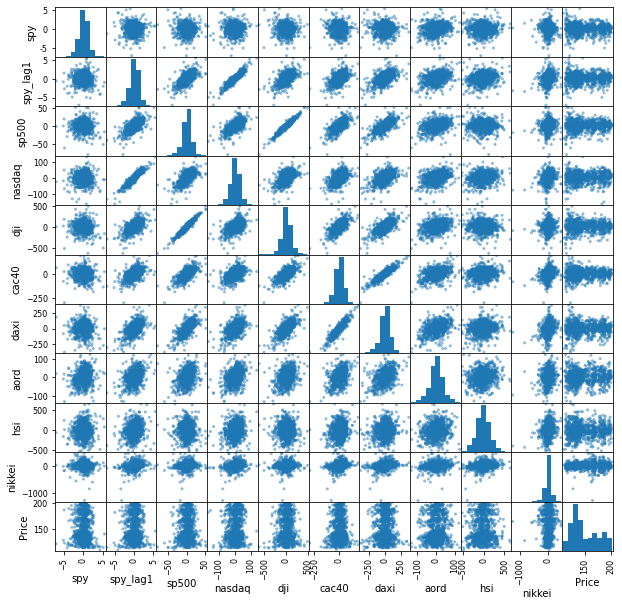

In [12]:
sm = scatter_matrix(train, figsize=(10, 10))

### Step 4: check the correlation of each index between spy

In [20]:
train.iloc[:, :-1].corr()['spy']

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64

<AxesSubplot:>

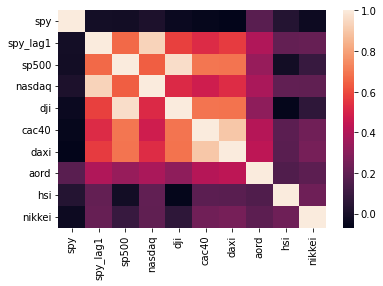

In [19]:
sns.heatmap(train.iloc[:, :-1].corr())

In [22]:
formula = "spy ~ spy_lag1 + sp500 + nasdaq + dji + cac40 + aord + daxi + nikkei + hsi"
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Tue, 19 Jul 2022   Prob (F-statistic):           1.97e-11
Time:                        20:19:59   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 5: make prediction

In [23]:
train["predicted"] = lm.predict(train)
test["predicted"] = lm.predict(test)

/tmp/ipykernel_85091/1366996542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["predicted"] = lm.predict(train)
/tmp/ipykernel_85091/1366996542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted"] = lm.predict(test)


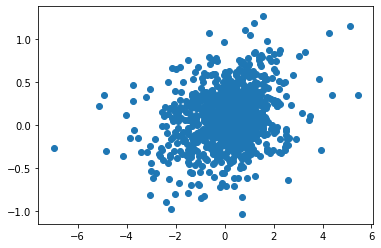

In [24]:
plt.scatter(train["spy"], train["predicted"])

### Step 6: model evaluation

In [28]:
assessTable(test, train, lm, 9, 'spy')

/tmp/ipykernel_85091/3376232487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)
/tmp/ipykernel_85091/3376232487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)


Train      Test
R2    0.059020  0.067248
RMSE  1.226068  1.701291